In [1]:
import torch
import pandas as pd
from matplotlib import pyplot as plt
from basis import *
import nf_library

device = torch.device('cpu')

In [2]:
mu_a,sig_a = 100,31.62
scale_gt=1

In [3]:
x = torch.tensor(pd.read_csv('datasets/N_{}_{}_E_{}.csv'.format(mu_a,sig_a,scale_gt),header=None).to_numpy()[:10000].reshape(-1))
bins = torch.linspace(x.min(),x.max(),21).numpy()
bins = torch.linspace(x.min(),501,21).numpy()
xb = torch.linspace(1e-3,(x.max().item()/mu_a),10000).reshape(-1).to(device)
xb = torch.linspace(1e-3,5,10000).reshape(-1).to(device)
p_gt = torch.exp(logprob_exp(xb,torch.tensor(scale_gt)))


In [4]:
def Bayes_fig(ax,N):
    filename = 'models/prod_bayes_N_{}_{}_E_{}_datapoints{}.csv'.format(mu_a,sig_a,scale_gt,N)
    scale,lps =  torch.tensor(pd.read_csv(filename).to_numpy()[:,1:].T)

    i = torch.argmax(lps)
    p_map = torch.exp(logprob_exp(xb,scale[i]))


    logp = torch.logsumexp(torch.vstack([logprob_exp(xb,sc) for sc in scale]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP'.format(KL(p_gt,p_map,xb)))
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction'.format(KL(p_gt,p,xb)))
    ax.legend()

def logprob_mixlognormal(x,mus,sigs,rhos):
    return torch.logsumexp(logprob_gaussian(torch.log(x),mus.reshape(-1,1),sigs.reshape(-1,1))
                           -torch.log(x)
                           +torch.log(rhos.reshape(-1,1)),axis=0)

def Mixture_fig(ax,N,Ncomp=5,burn=5000):

    logprob_mixgaussian = lambda x,mus,sigs,rhos:torch.logsumexp(logprob_gaussian(x,mus.reshape(-1,1),sigs.reshape(-1,1))+torch.log(rhos.reshape(-1,1)),axis=0)
    filename = 'models/prod_bayes_WM_N_{}_{}_E_{}_datapoints{}.csv'.format(mu_a,sig_a,scale_gt,N)
    g = pd.read_csv(filename).to_numpy()[:,1:]
    thetas,lps = torch.tensor(g[burn:,:-1]),torch.tensor(g[burn:,-1])

    i = torch.argmax(lps)
    
    th_map = thetas[i]
    p_map = torch.exp(logprob_mixlognormal(xb,th_map[:Ncomp],th_map[Ncomp:2*Ncomp],th_map[2*Ncomp:]))

    logp = torch.logsumexp(torch.vstack([logprob_mixlognormal(xb,th[:Ncomp],th[Ncomp:2*Ncomp],th[2*Ncomp:]) for th in thetas]),axis=0)-torch.log(torch.tensor(len(lps))).to(device)
    p = torch.exp(logp)
    
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_map.cpu(),label='MAP')
    ax.plot(xb.cpu(),p.cpu(),label='Reconstruction')
    ax.legend()


def NF_fig(ax,N):
    model = nf_library.NormalizingFlow_sim(device)
    model.load_state_dict(torch.load('models/prod_nf_N_{}_{}_E_{}_datapoints{}.pt'.format(mu_a,sig_a,scale_gt,N).format(N)))
    p_nf = torch.exp(model.log_prob(xb.reshape(-1,1))).detach()
    ax.plot(xb.cpu(),p_gt.cpu(),label='Ground Truth ', lw = 2.0,color='k')
    ax.plot(xb.cpu(),p_nf.cpu(),label='NF',color='r')
    ax.legend()


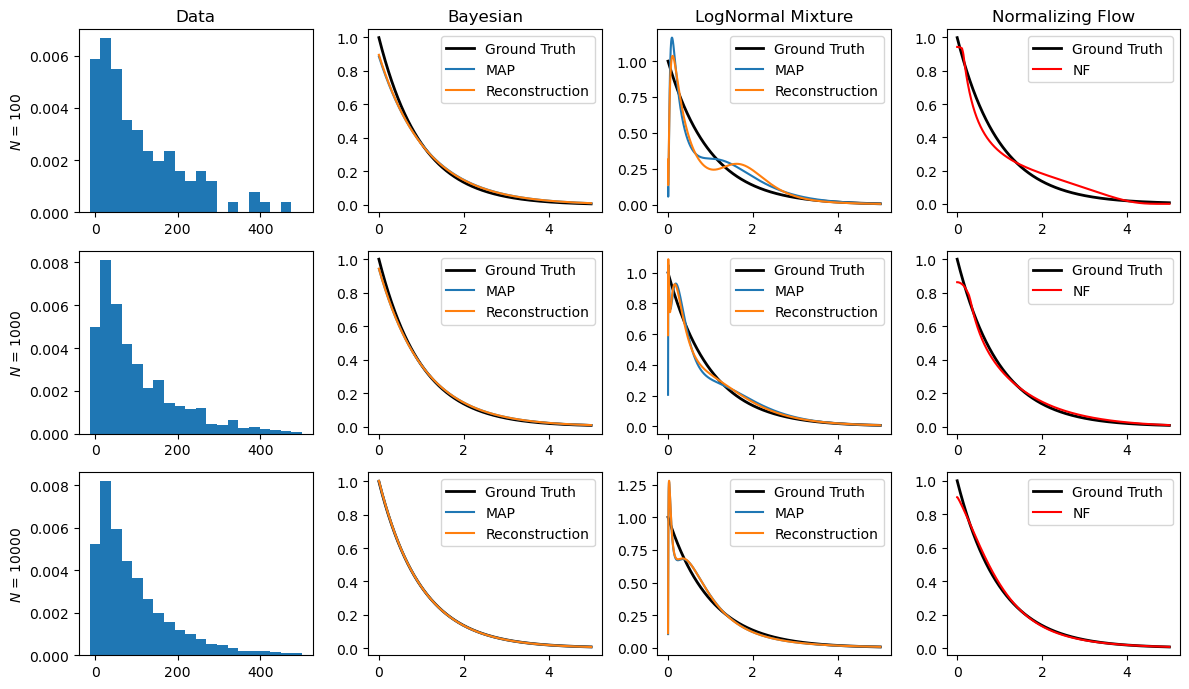

In [5]:
fig,axs = plt.subplots(3,4,figsize=(12,7))
for (ax,N) in zip(axs,(100,1000,10000)):
    ax[0].hist(x[:N],density=True,bins=bins)
    Bayes_fig(ax[1],N)
    Mixture_fig(ax[2],N)
    NF_fig(ax[3],N)

    ax[0].set_ylabel(r'$N$ = {}'.format(N))

[ax.set_title(tit) for (tit,ax) in zip(('Data', 'Bayesian', 'LogNormal Mixture', 'Normalizing Flow'), axs[0])]
plt.tight_layout()
plt.savefig('graphs/fig3.png',dpi=300)